<a href="https://colab.research.google.com/github/Fondzenyuy/Google-Collab/blob/main/Successful%20Predict%20ML_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data&Inputs

In [1]:
#!pip install optuna # for hyperparameter tuning

In [2]:
import sys, os, time
import matplotlib.pyplot as plt
import numpy as np
#import optuna
#from optuna.trial import TrialState
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch.nn.functional import normalize
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
#from tqdm import tqdm  # For nice progress bar!
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(1)

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 14 22:09:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: Tesla P100-PCIE-16GB
__CUDA Device Total Memory [GB]: 17.071734784


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES = 10000, noise_std=1, train=True):
        self.len = N_SAMPLES
        self.x = (torch.linspace(-1, 1, N_SAMPLES).view(-1, 1))
        min_x, max_x = torch.min(self.x), torch.max(self.x)
        self.x = self.x/(max_x - min_x)

        self.f = ((self.x)*torch.sin(20*self.x) - ((self.x)**2)*torch.cos(10*self.x))  #key function in model for outputs
        min_f , max_f = torch.min(self.f), torch.max(self.f)
        self.f = self.f/(max_f - min_f)



        if train != True:
            torch.manual_seed(1)
            self.y = self.f 
            self.y = self.y.view(-1, 1)
            #self.y = (self.y).to(device)
            torch.manual_seed(1)
        else:
            self.y = self.f 
            self.y = self.y.view(-1, 1)
            #self.y = (self.y).to(device)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [7]:
data_set = Data()
len(data_set)

10000

In [8]:
batch_size = 64
train_loader = DataLoader(data_set, shuffle= True, batch_size = batch_size)
validation_loader = DataLoader(Data(train= False), shuffle = True, batch_size = batch_size)

# Hyp Param Tuning (Trial 2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import optuna
optuna.logging.disable_default_handler()



# Build neural network model
# Simple CNN
class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0.5):
      super(Net, self).__init__()
      self.drop = nn.Dropout(p=p)
      self.linear1 = nn.Linear(in_size, n_hidden)
      self.linear2 = nn.Linear(n_hidden, n_hidden)
      self.linear3 = nn.Linear(n_hidden, out_size)

      
        
    def forward(self, x):

      # x = F.relu(self.drop(self.linear1(x))).to(device)
      
      x = self.linear1(x)
      x = self.drop(x)
      x = F.relu(x)

      x = F.relu(self.drop(self.linear2(x)))
      x = self.linear3(x)
      return x

# Initialize network

model = Net(1,100,1, p =0.5).to(device)  

In [ ]:

def train(model, device, train_loader, optimizer):
  model.train()
  for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        
def test(model, device, validation_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x,y in validation_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    return 1 - correct / len(validation_loader.dataset)

In [ ]:
def get_model(model_name: str = "resnet18"):  
    if model_name == "resnet18":
        model = torchvision.models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 2)
    elif model_name == "alexnet":
        model = torchvision.models.alexnet(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Linear(in_features, 2)
    elif model_name == "vgg16":
        model = torchvision.models.vgg16(pretrained=True)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, 2)
    return model

In [ ]:

sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=5, interval_steps=3
    ),
    direction='minimize')
study.optimize(func=objective, n_trials=40)

Trial 0 failed because of the following error: TypeError("trainhyp() missing 1 required positional argument: 'criterion'")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-129-dd9e8fe8f960>", line 51, in objective
    best_model = trainhyp(trial, model, criterion, optimizer, num_epochs=20)
TypeError: trainhyp() missing 1 required positional argument: 'criterion'


TypeError: ignored

# Hyperparameter Tuning

Each of Optuna hyperparameter tuning session is called `study` . We instantiate a study session by calling `create_study` method. We can pass a couple of important arguments into this method as follows.

In [ ]:
#we pass direction and sampler variables as arguments into create_study method.
#study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler()) 
#study.optimize(objective, n_trials=30)    #objective function is gotten by defining the search space.
#Search space is the range of value that the sampler should consider from a hyperparameter.


In [ ]:

# Build neural network model
# Simple CNN
class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0.5):
      super(Net, self).__init__()
      self.drop = nn.Dropout(p=p)
      self.linear1 = nn.Linear(in_size, n_hidden)
      self.linear2 = nn.Linear(n_hidden, n_hidden)
      self.linear3 = nn.Linear(n_hidden, out_size)

      
        
    def forward(self, x):

      # x = F.relu(self.drop(self.linear1(x))).to(device)
      
      x = self.linear1(x)
      x = self.drop(x)
      x = F.relu(x)

      x = F.relu(self.drop(self.linear2(x)))
      x = self.linear3(x)
      return x
#Initialize network
device = torch.device("cuda" if use_cuda else "cpu")
modelhyp = Net(1, 100, 1, p=0.5).to(device)
 
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(param, model):
    
    
    
    #train_data, val_data = train_test_split(df, test_size = 0.2, random_state = 42)
    train_loader = DataLoader(data_set, shuffle= True) #, batch_size = 2) #batch_size)
    validation_loader = DataLoader(Data(train= False), shuffle = True) #, batch_size = 2) #batch_size = batch_size)
    #train, val = Dataset(train_data), Dataset(val_data)

    

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for x,y in train_loader:

                x = x.to(device)
                y = y.to(device)

                output = model(x, return_dict=False)
                
                batch_loss = criterion(output, y)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == y).sum().item()
                total_acc_train += acc

                modelhyp.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for x, y in validation_loader:

                    x = x.to(device)
                    y = y.to(device)

                    output = model(x)

                    batch_loss = criterion(output, y)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == y).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(data_set)

    return accuracy
  
 # Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):
  #generate the model
  model = modelhyp(trial).to(device)
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  lr = trial.suggest_float('learning_rate', 1e-5, 1e-1)
  optimizer = getattr(optim, optimizer_name)(modelhyp.parameters(), lr= lr)


  #model training
  
  for epoch in range(EPOCHS):
    trial.report(accuracy,epoch)

    #handle pruning based on the intermediate value
    if trial.should_prune():
      raise optuna.exceptions.Trial_Pruned()

    
     
    
     #accuracy = train_and_evaluate(params, modelhyp, trial)

return accuracy

In [ ]:
# run hyperparams tuning

EPOCHS = 2
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-08-04 20:53:59,290] A new study created in memory with name: no-name-ac65859e-5b83-4bf6-83aa-7146d9971aa9
[W 2022-08-04 20:53:59,293] Trial 0 failed because of the following error: TypeError("linear(): argument 'input' (position 1) must be Tensor, not dict")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-47-1f7214681150>", line 106, in objective
    model = modelhyp(params)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-47-1f7214681150>", line 19, in forward
    x = self.linear1(x)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/linear.py", line 114, in forward
  

TypeError: ignored

In [ ]:
device

device(type='cuda')

# Using Hyperparameters

In [9]:
# sample Hyperparameters

learning_rate = 1e-3
batch_size = 64
num_epochs = 100
#num_epochs = 1200

In [10]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss= 1e6)    :     #float('inf'))
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
      if current_valid_loss < self.best_valid_loss:
        self.best_valid_loss = current_valid_loss
        print(f"\nBest validation loss: {self.best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
        torch.save({'epoch': epoch+1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': criterion}, 'weights_only.pth')
    
    
      

# initialize SaveBestModel class
save_best_model = SaveBestModel()
            

In [11]:
def save_model(epochs, model, optimizer, criterion) :
      """
      Function to save the trained model to disk.
      """
      print(f"Saving final model...")
      torch.save({'epoch': epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': criterion}, 'weights_only.pth')
      #We will call this function after the training iterations for all the epochs are complete.


In [12]:
def save_plots(train_loss, valid_loss):
      """
      Function to save the loss plots to disk.
      """
      
      
      # loss plots
      plt.figure(figsize=(10, 7))
      plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
      plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      #plt.savefig('outputs/loss.png')

# CNN

In [ ]:



# Simple CNN
class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0.5):
      super(Net, self).__init__()
      self.drop = nn.Dropout(p=p)
      self.linear1 = nn.Linear(in_size, n_hidden)
      self.linear2 = nn.Linear(n_hidden, n_hidden)
      self.linear3 = nn.Linear(n_hidden, out_size)

      
        
    def forward(self, x):

      # x = F.relu(self.drop(self.linear1(x))).to(device)
      
      x = self.linear1(x)
      x = self.drop(x)
      x = F.relu(x)

      x = F.relu(self.drop(self.linear2(x)))
      x = self.linear3(x)
      return x

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Pre-training: Loaders, Helper Functions & Model Setup

In [ ]:

train_loader = DataLoader(data_set, shuffle= True, batch_size = batch_size)
validation_loader = DataLoader(Data(train= False), shuffle = True, batch_size = batch_size) #use percent of data for validation
#val_xtrain = (validation_set.x).to(device=device)
#val_ytrain = (validation_set.y).to(device=device)



In [ ]:
# Initialize network
#model = Net(1,500,1).to(device)
model_drop = Net(1, 800, 1, p=0.5).to(device)
#model.train()
model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=800, bias=True)
  (linear2): Linear(in_features=800, out_features=800, bias=True)
  (linear3): Linear(in_features=800, out_features=1, bias=True)
)

In [ ]:
# Set the optimizer and criterion(loss) function


optimizer_drop = torch.optim.Adam(model_drop.parameters(), learning_rate)
criterion = torch.nn.MSELoss()

In [ ]:
data = (data_set.x).to(device=device)
target = (data_set.y).to(device=device)
#val_xtrain = (validation_set.x).to(device=device)
#val_ytrain = (validation_set.y).to(device=device)



def train(model, trainloader, optimizer, criterion):
    model.train()
    #print('Training')
    train_running_loss = 0.0
    counter = 0
    for x,y in train_loader:
 
        # forward pass
        x = x.to(device)
        y = y.to(device)  
        outputs = model(x)
        # calculate the loss
        loss = criterion(outputs, y)
        train_running_loss += loss.item()
        counter += x.shape[0]
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss for the complete epoch
    epoch_loss = train_running_loss / counter
    
    return epoch_loss

# validation : rem our validation loader is called 'validation_set'
def validate(model, testloader, criterion):
    model.eval()
    #print('Validation')
    valid_running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for x,y in testloader:
            
            # forward pass
            x = x.to(device)
            y = y.to(device)  
            outputs = model(x)
            # calculate the loss
            loss = criterion(outputs, y)
            valid_running_loss += loss.item()
            counter += x.shape[0]
            
            
        
    # loss for the complete epoch
    epoch_loss = valid_running_loss / counter
    
    
    return epoch_loss


# Training

[INFO]: Epoch 1 of 1200
Training loss: 0.001
Validation loss: 0.001

Best validation loss: 0.0008674070332199335

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 1200
Training loss: 0.001
Validation loss: 0.001

Best validation loss: 0.0007816638421267271

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 1200
Training loss: 0.001
Validation loss: 0.001

Best validation loss: 0.0006915916403755545

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 1200
Training loss: 0.001
Validation loss: 0.001

Best validation loss: 0.0006173386780545116

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 1200
Training loss: 0.001
Validation loss: 0.000

Best validation loss: 0.0004063325146213174

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6

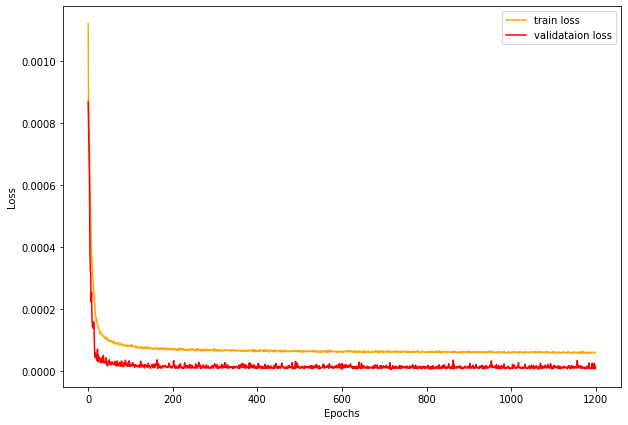

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []

# start the training
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss = train(model_drop, train_loader,optimizer_drop, criterion)
    valid_epoch_loss = validate(model_drop, validation_set, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
    print(f"Training loss: {train_epoch_loss:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(valid_epoch_loss, epoch, model_drop, optimizer_drop, criterion)
    print('-'*50)
    
# save the trained model weights for a final time
save_model(num_epochs, model_drop, optimizer_drop, criterion)
# save the loss and accuracy plots
save_plots(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [ ]:
# Analysis:

#Set the model with dropout to evaluation mode

#model_drop.eval()

# Make the prediction
#output = model_drop(data)
#plt.plot(data.to("cpu").numpy(), data_set.f.numpy(),label="True function", color='orange')
#plt.plot(data.to("cpu").numpy(), output.to("cpu").detach().numpy() , label="Plot after training data", c ='g')
#plt.title('Plot of trained versus true models of a complex trigonometric function')
#plt.xlabel("x")
#plt.ylabel("y")
#plt.xlim((-1, 1))
#plt.ylim((-2, 2.5))
#plt.legend(loc = "best")
#plt.show()

In [ ]:
# Make predictions with model
X_test = data
X_test = (data)
with torch.inference_mode(): 
    y_preds = model_drop(X_test)

print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10000
Number of predictions made: 10000
Predicted values:
tensor([[-0.3170],
        [-0.3162],
        [-0.3154],
        ...,
        [-0.2940],
        [-0.2943],
        [-0.2945]], device='cuda:0')


In [ ]:
a = data[1000]
b =  (a)*torch.sin(20*a) - ((a)**2)*torch.cos(10*a)
b

tensor([0.5003], device='cuda:0')

In [ ]:
y_preds[1000]

tensor([0.5141], device='cuda:0')

In [ ]:
criterion(data[1000],y_preds[1000])

tensor(0.8355, device='cuda:0')

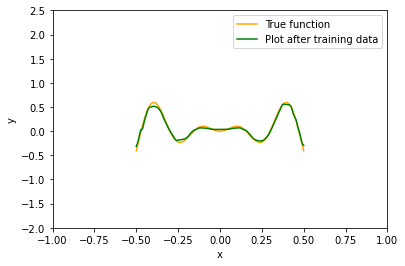

In [ ]:
# Analysis:

#Set the model with dropout to evaluation mode

model_drop.eval()

# Make the prediction
output = model_drop(data)
plt.plot(data.to("cpu").numpy(), data_set.f.numpy(),label="True function", color='orange')
plt.plot(data.to("cpu").numpy(), output.to("cpu").detach().numpy() , label="Plot after training data", c ='g')
#plt.title('Plot of trained versus true models of a complex trigonometric function')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

In [ ]:
#keystones: optimizer zero grad